<a href="https://colab.research.google.com/github/patrick-hanley/thought_experiments/blob/master/fastai_crunchbase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#fastai and crunchbase

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install fastai --upgrade --q

     |████████████████████████████████| 194kB 5.6MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 


In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
base_dir = root_dir + 'crunchbase'
path = Path(base_dir)
csv_path = Path(base_dir+'/crunchbase_v1.csv')

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
X=df.copy()
y=X.status

X.drop('status',inplace=True, axis=1)
categorical_features_indices = np.where(X.dtypes == 'object')[0]

In [ ]:
dep_var = 'status'
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
from sklearn.model_selection import train_test_split
# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
splits = (list(X_train.index),list(X_test.index))

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(2784, 696)

In [ ]:
save_pickle(path/'to.pkl',to)

#load saved data

In [ ]:
to = load_pickle(path/'to.pkl')

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [ ]:
#!pip install dtreeviz --q --upgrade

In [ ]:

#from dtreeviz.trees import *

In [ ]:
#draw_tree(m, xs, size=10,  precision=2)

In [ ]:
import IPython
import graphviz

def mydraw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [ ]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

NameError: ignored

#decision tree


In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=15)
m.fit(to.train.xs, to.train.y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=35)
clf.fit(to.train.xs, to.train.y)
clf.score(to.train.xs, to.train.y), clf.score(to.valid.xs,to.valid.y)

(0.7262931034482759, 0.6767241379310345)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True, min_samples_split=30)
clf.fit(to.train.xs, to.train.y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.score(to.train.xs, to.train.y)

0.8538074712643678

In [ ]:
clf.score(to.valid.xs,to.valid.y)

0.7183908045977011

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(clf, to.valid.xs)
fi[:10]

,cols,imp
334,int_funding_total_usd,0.095258
339,ave_rounds_per_year,0.067291
310,funding_total_usd,0.062829
314,venture,0.061677
336,first_funding_year,0.038463
312,founded_year,0.037137
337,last_funding_year,0.035763
4,city,0.035051
311,funding_rounds,0.030932
0,market,0.030755


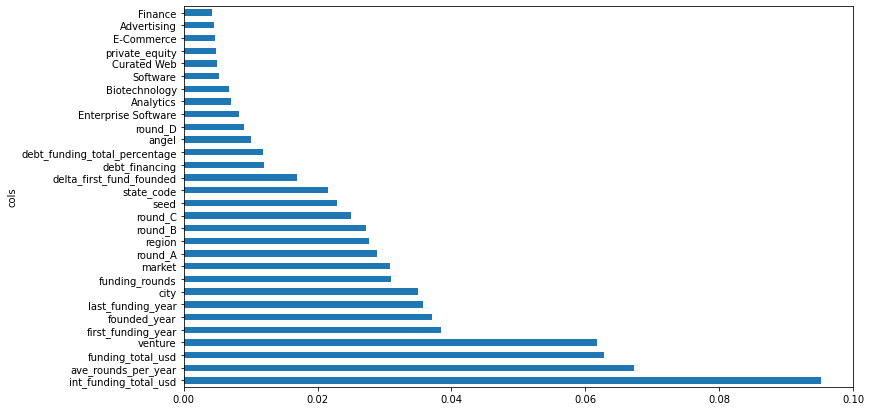

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
#to_keep = fi[fi.imp>0.005].cols
to_keep = fi[fi.imp>0.03].cols
print (len(to_keep))

xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

10

In [ ]:
clf.fit(xs_imp, to.train.y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.score(valid_xs_imp,to.valid.y)

0.7112068965517241

In [ ]:
list(xs_imp.columns), xs_imp.shape

(['int_funding_total_usd',
  'ave_rounds_per_year',
  'funding_total_usd',
  'venture',
  'first_funding_year',
  'founded_year',
  'last_funding_year',
  'city',
  'funding_rounds',
  'market'],
 (2784, 10))

# NN comparison

In [ ]:
#to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

df = pd.read_csv(csv_path)
y=df.status
X=df.copy()
X.drop(['status'],axis=1,inplace=True)

In [ ]:
dep_var = 'status'
df_nn_final = df[list(xs_imp.columns) + [dep_var]]

In [ ]:
list(df_nn_final.columns), df_nn_final.shape

(['int_funding_total_usd',
  'ave_rounds_per_year',
  'funding_total_usd',
  'venture',
  'first_funding_year',
  'founded_year',
  'last_funding_year',
  'city',
  'funding_rounds',
  'market',
  'status'],
 (3480, 11))

In [ ]:
y=df_nn_final.status
X=df_nn_final.copy()
X.drop(['status'],axis=1,inplace=True)

In [ ]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
splits = (list(X_train.index),list(X_test.index))

In [ ]:
X_train.shape

(2784, 10)

In [ ]:
df_nn_final = df_nn_final.astype({'int_funding_total_usd': 'int64',
                                  'first_funding_year':'int64',
                                  'founded_year':'int64',
                                  'last_funding_year':'int64',
                                  'funding_rounds':'int64',
                                  'venture': 'int64'})

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=10, dep_var=dep_var)


In [ ]:
df_nn_final.dtypes

int_funding_total_usd      int64
ave_rounds_per_year      float64
funding_total_usd          int64
venture                    int64
first_funding_year         int64
founded_year               int64
last_funding_year          int64
city                      object
funding_rounds             int64
market                    object
status                      bool
dtype: object

In [ ]:
new_types = df_shrink_dtypes(df_nn_final)

In [ ]:
df_nn_final = df_nn_final.astype(new_types)

In [ ]:
df_nn_final[cat_nn].nunique(), df_nn_final[cont_nn].nunique()

(city      582
 market    347
 dtype: int64, int_funding_total_usd    1522
 ave_rounds_per_year      1636
 funding_total_usd        1522
 venture                  1160
 first_funding_year         16
 founded_year               14
 last_funding_year          14
 funding_rounds             11
 dtype: int64)

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(512)

In [ ]:
learn = tabular_learner(dls,layers=[1000,500],metrics=accuracy ,emb_szs={'city':2, 'market':2})

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0020892962347716093)

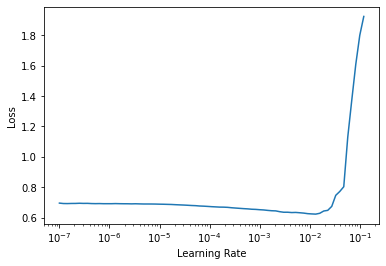

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, .001)

epoch,train_loss,valid_loss,accuracy,time
0,0.667300,0.641926,0.635057,00:00
1,0.643535,0.644610,0.622126,00:00
2,0.626950,0.627442,0.655172,00:00
3,0.608407,0.621140,0.673851,00:00
4,0.588778,0.619871,0.666667,00:00
5,0.571686,0.616398,0.675287,00:00
6,0.558026,0.617224,0.666667,00:00


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learn.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

In [ ]:
embeded_xs = embed_features(learn, learn.dls.train.xs)
xs_valid = embed_features(learn, learn.dls.valid.xs)

In [ ]:
#clf = RandomForestClassifier(max_depth=50, random_state=0, oob_score=True, min_samples_split=30, min_samples_leaf=50)
clf = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True, min_samples_split=30)
clf.fit(embeded_xs, learn.dls.targ)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.score(embeded_xs, learn.dls.targ)

0.8394396551724138

In [ ]:
clf.score(xs_valid, y_test)

0.6867816091954023

In [ ]:
# Lets loop over embedding sizes (0,1,2,4,8,16,32,64)
embedding_sizes = [0,1,2,4,8,16,32,64,128]
for es in embedding_sizes:
 

  embeded_xs = embed_features(learn, learn.dls.train.xs)
  xs_valid = embed_features(learn, learn.dls.valid.xs)
  clf = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True, min_samples_split=30)
  learn = tabular_learner(dls,layers=[2000,1000],metrics=accuracy , emb_szs={'city':es+2, 'market':es})
  learn.fit_one_cycle(6, .0001, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=2))
  clf.fit(embeded_xs, learn.dls.targ)
  trn=clf.score(embeded_xs, learn.dls.targ)
  val=clf.score(xs_valid, y_test)
  print(es, trn, val)

epoch,train_loss,valid_loss,accuracy,time
0,0.679807,0.663571,0.617816,00:01
1,0.652834,0.634586,0.652299,00:01
2,0.637037,0.633504,0.669540,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


0 0.8297413793103449 0.7155172413793104


epoch,train_loss,valid_loss,accuracy,time
0,0.676454,0.661646,0.622126,00:01
1,0.655459,0.637066,0.639368,00:01
2,0.640021,0.629893,0.656609,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


1 0.8132183908045977 0.7140804597701149


epoch,train_loss,valid_loss,accuracy,time
0,0.696407,0.668240,0.630747,00:01
1,0.661972,0.632339,0.637931,00:01
2,0.642509,0.636022,0.649425,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


2 0.8139367816091954 0.7112068965517241


epoch,train_loss,valid_loss,accuracy,time
0,0.696265,0.673092,0.610632,00:01
1,0.666440,0.639607,0.627874,00:01
2,0.646126,0.634086,0.660920,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


4 0.8318965517241379 0.7212643678160919


epoch,train_loss,valid_loss,accuracy,time
0,0.688217,0.674222,0.625000,00:01
1,0.656905,0.642816,0.639368,00:01
2,0.635560,0.629666,0.652299,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


8 0.8462643678160919 0.7313218390804598


epoch,train_loss,valid_loss,accuracy,time
0,0.680937,0.677009,0.617816,00:01
1,0.655997,0.647017,0.616379,00:01
2,0.631142,0.637035,0.645115,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


16 0.8448275862068966 0.7169540229885057


epoch,train_loss,valid_loss,accuracy,time
0,0.689438,0.682759,0.625000,00:01
1,0.663272,0.656915,0.627874,00:01
2,0.636868,0.640105,0.642241,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


32 0.8681752873563219 0.7083333333333334


epoch,train_loss,valid_loss,accuracy,time
0,0.702382,0.691412,0.570402,00:01
1,0.670564,0.668719,0.633621,00:01
2,0.639978,0.649089,0.627874,00:01


No improvement since epoch 0: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


64 0.8732040229885057 0.6853448275862069


epoch,train_loss,valid_loss,accuracy,time
0,0.740962,0.695669,0.442529,00:01
1,0.701192,0.681980,0.594828,00:01
2,0.657554,0.666407,0.632184,00:01
3,0.624378,0.655734,0.630747,00:01


No improvement since epoch 1: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


128 0.8825431034482759 0.6968390804597702


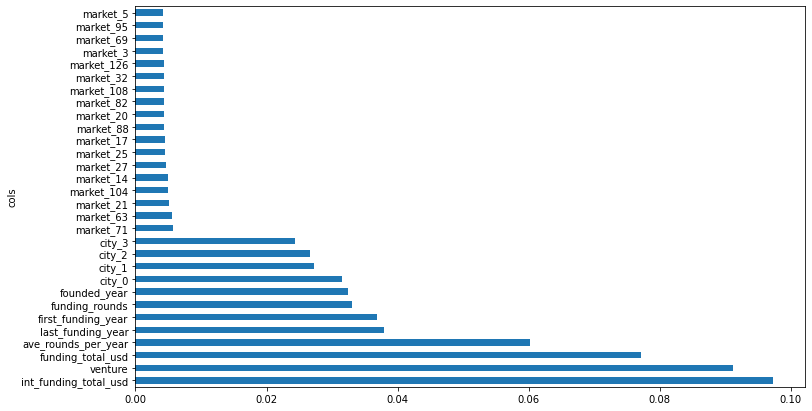

In [ ]:
fi = rf_feat_importance(clf, xs_valid)
plot_fi(fi[:30]);

# compare df of nn and random foresst
aare they different? - No, they are the same
# remove embeddings 1 by 1 until get closer,
 needed to remove embeddings to see improvement (WTF????)
# remove similar items?
https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html



# remove embeddings and get models for dt, rf, and xgb


In [ ]:
embeded_xs['city']=xs.city
xs_valid['city']=valid_xs.city
embeded_xs['market']=xs.market
xs_valid['market']=valid_xs.market

In [ ]:
def drop_embedded(df, name, max_int):
  for i in range(max_int):
    val=name+"_"+str(i)
    try:
      df.drop(val, axis=1, inplace=True)
    except:
      #do nothing
      print('.',end='')

drop_embedded(embeded_xs, 'city', 70)
drop_embedded(xs_valid, 'city', 70)

............................................................................................................................................

In [ ]:
drop_embedded(embeded_xs, 'market', 70)
drop_embedded(xs_valid, 'market', 70)

..........................................................................................................................................

In [ ]:
embeded_xs[:2]

,int_funding_total_usd,ave_rounds_per_year,funding_total_usd,venture,first_funding_year,founded_year,last_funding_year,funding_rounds,city,market
37,-0.137297,-0.165169,-0.137297,-0.357561,0.049577,0.445981,-0.478425,-0.752694,462,266
890,-0.137239,-0.194551,-0.137239,-0.357309,0.441685,0.772035,0.366176,0.673301,63,284


In [ ]:
clf = RandomForestClassifier(max_depth=900, random_state=0, oob_score=True, min_samples_split=25,  n_estimators=400)
clf.fit(embeded_xs, learn.dls.targ)
clf.score(embeded_xs, learn.dls.targ), clf.score(xs_valid, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(0.8297413793103449, 0.7270114942528736)

In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=0, oob_score=False, min_samples_split=50)
clf.fit(embeded_xs, learn.dls.targ)
print (clf.score(xs_valid, y_test))

rf_prob_no_ebedding = clf.predict_proba(xs_valid)
prf_prob_no_ebedding = pd.DataFrame(rf_prob_no_ebedding, columns=['rf_0_no_ebedding','rf_1_no_ebedding']).astype("float")
prf_prob_no_ebedding[:4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.728448275862069


,rf_0_no_ebedding,rf_1_no_ebedding
0,0.436021,0.563979
1,0.392478,0.607522
2,0.455046,0.544954
3,0.308228,0.691772


#XGBoost


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# fit model no training data
model = XGBClassifier(max_depth=3,n_estimators=100,learning_rate=.01)
model.fit(embeded_xs, learn.dls.targ)
print(model, model.score(embeded_xs, learn.dls.targ), model.score(xs_valid, y_test))

xgb_prob_no_ebedding = clf.predict_proba(xs_valid)
pxgb_prob_no_ebedding = pd.DataFrame(xgb_prob_no_ebedding, columns=['xgb_0_no_ebedding','xgb_1_no_ebedding']).astype("float")


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 0.7011494252873564 0.7399425287356322


,rf_0_no_ebedding,rf_1_no_ebedding
0,0.436021,0.563979
1,0.392478,0.607522
2,0.455046,0.544954
3,0.308228,0.691772


# found best by adjusting embedding size.
# now do PCA of train and test
https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

#ultimately, want to pca successful and inprogress to find next company purchase

In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=2)
pca.fit(embeded_xs)
X = pca.transform(embeded_xs)

In [ ]:
y = learn.dls.targ
X[:4]

array([[-131.17435781,  104.30262778],
       [ 267.78482864,  123.18415853],
       [  69.3481338 , -131.2547143 ],
       [-130.75801752,  -83.69775359]])

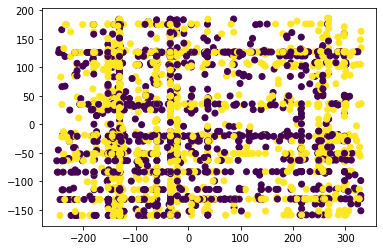

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y.values) # this is pca without embeddings

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y.values, marginal_y="violin",
           marginal_x="box", trendline="ols")

In [ ]:
fig.show()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
X_embedded = tsne.fit_transform(embeded_xs)

In [ ]:
learn.dls.targ[:4]

,status
37,0
890,0
1422,1
2843,1


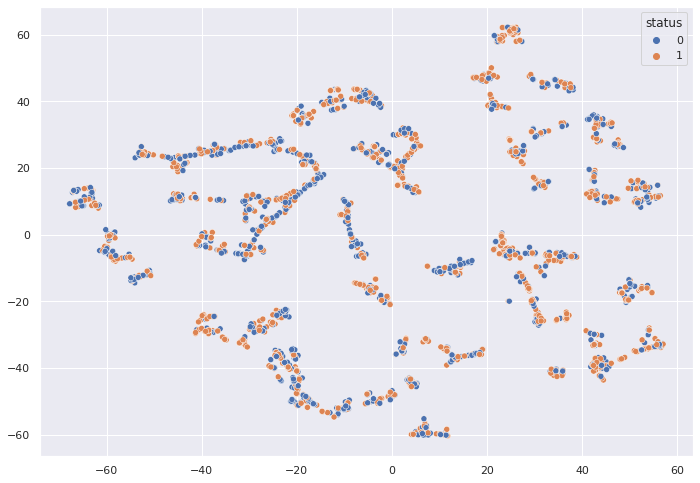

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

sns.scatterplot(data=X_embedded, x=X_embedded[:,0], y=X_embedded[:,1], hue=learn.dls.targ.status)

#combine nn, rf+nn_ebeddings, xgb+nn_ebeddings


In [ ]:

# clf = RandomForestClassifier(max_depth=200,random_state=0, oob_score=True, min_samples_split=30)
learn = tabular_learner(dls,layers=[2000,1000],metrics=accuracy , emb_szs={'city':6, 'market':4})
learn.fit_one_cycle(6, .0001, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=2))
# clf.fit(embeded_xs, learn.dls.targ)

# after fitting, get embeddings to be used by ML
embeded_xs = embed_features(learn, learn.dls.train.xs)
xs_valid = embed_features(learn, learn.dls.valid.xs)

epoch,train_loss,valid_loss,accuracy,time
0,0.666141,0.665151,0.616379,00:01
1,0.647635,0.639139,0.637931,00:01
2,0.632486,0.633156,0.656609,00:01


No improvement since epoch 0: early stopping


In [ ]:
embeded_xs[:2]

,int_funding_total_usd,ave_rounds_per_year,funding_total_usd,venture,first_funding_year,founded_year,last_funding_year,funding_rounds,city_0,city_1,city_2,city_3,city_4,city_5,market_0,market_1,market_2,market_3
37,-0.137297,-0.165169,-0.137297,-0.357561,0.049577,0.445981,-0.478425,-0.752694,-0.01895,-0.000985,0.004448,0.005378,0.005506,0.016860,-0.011969,0.005263,-0.002732,0.002696
890,-0.137239,-0.194551,-0.137239,-0.357309,0.441685,0.772035,0.366176,0.673301,-0.00144,-0.013325,-0.010980,-0.001111,-0.008261,-0.006416,0.015534,0.007746,0.002009,-0.005920


In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=0, oob_score=False, min_samples_split=50)
clf.fit(embeded_xs, learn.dls.targ)
clf.score(xs_valid, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7140804597701149

In [ ]:
nn_preds,targs = learn.get_preds() #this is validaation predictions
pnn = pd.DataFrame(nn_preds,columns=['nn_0','nn_1']).astype("float")
pnn[:4]

,nn_0,nn_1
0,0.521970,0.478030
1,0.594045,0.405955
2,0.404652,0.595348
3,0.449059,0.550941


In [ ]:
model_embed = XGBClassifier(max_depth=3,n_estimators=100,learning_rate=.01)
model_embed.fit(embeded_xs, learn.dls.targ)
print (model_embed.score(xs_valid, y_test))
probabilities_xgb=model_embed.predict_proba(xs_valid)
pxgb = pd.DataFrame(probabilities_xgb,columns=['xgb_0','xgb_1']).astype("float")

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7341954022988506


In [ ]:
pxgb[:4]

,xgb_0,xgb_1
0,0.533651,0.466349
1,0.451584,0.548416
2,0.472964,0.527036
3,0.366464,0.633536


In [ ]:
clf = RandomForestClassifier(max_depth=50, random_state=0, oob_score=False, min_samples_split=50)
clf.fit(embeded_xs, learn.dls.targ)
print (clf.score(xs_valid, y_test))
rf_prob = clf.predict_proba(xs_valid)
prf = pd.DataFrame(rf_prob, columns=['rf_0','rf_1']).astype("float")
prf[:4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7140804597701149


,rf_0,rf_1
0,0.527853,0.472147
1,0.325712,0.674288
2,0.390194,0.609806
3,0.182892,0.817108


#Combine all models into a dataframe


In [ ]:
result = pd.concat([pnn, prf_prob_no_ebedding, prf, pxgb, pxgb_prob_no_ebedding ], axis=1, join="inner")
result['nn'] = (result.nn_1 - result.nn_0)
result['xgb'] = (result.xgb_1 - result.xgb_0)
result['rf'] =  (result.rf_1 - result.rf_0)
result['rf_no_embed'] = result.rf_1_no_ebedding - result.rf_0_no_ebedding
result['xgb_no_embed'] = result.xgb_1_no_ebedding - result.xgb_0_no_ebedding
result['confidence_total'] = (result.nn_1 - result.nn_0) + (result.xgb_1 - result.xgb_0) + \
(result.rf_1 - result.rf_0)+(result.rf_1_no_ebedding - result.rf_0_no_ebedding) + (result.xgb_1_no_ebedding - result.xgb_0_no_ebedding)
result[:4]

,nn_0,nn_1,rf_0_no_ebedding,rf_1_no_ebedding,rf_0,rf_1,xgb_0,xgb_1,xgb_0_no_ebedding,xgb_1_no_ebedding,nn,xgb,rf,rf_no_embed,xgb_no_embed,confidence_total
0,0.521970,0.478030,0.436021,0.563979,0.527853,0.472147,0.486101,0.513899,0.436021,0.563979,-0.043941,0.027798,-0.055706,0.127958,0.127958,0.184067
1,0.594045,0.405955,0.392478,0.607522,0.325712,0.674288,0.414256,0.585744,0.392478,0.607522,-0.188090,0.171488,0.348576,0.215044,0.215044,0.762063
2,0.404652,0.595348,0.455046,0.544954,0.390194,0.609806,0.456890,0.543110,0.455046,0.544954,0.190697,0.086221,0.219611,0.089909,0.089909,0.676346
3,0.449059,0.550941,0.308228,0.691772,0.182892,0.817108,0.380172,0.619828,0.308228,0.691772,0.101883,0.239656,0.634215,0.383544,0.383544,1.742843


In [ ]:
X=result.copy()
y=targs
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [ ]:
clf = RandomForestClassifier(max_depth=7, random_state=0, oob_score=False, min_samples_split=100,n_estimators=50)
clf.fit(X_train, y_train)
#clf.score(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7714285714285715

In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0, oob_score=False, min_samples_split=100, n_estimators=5)
clf.fit(X_train, y_train)
#clf.score(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7785714285714286

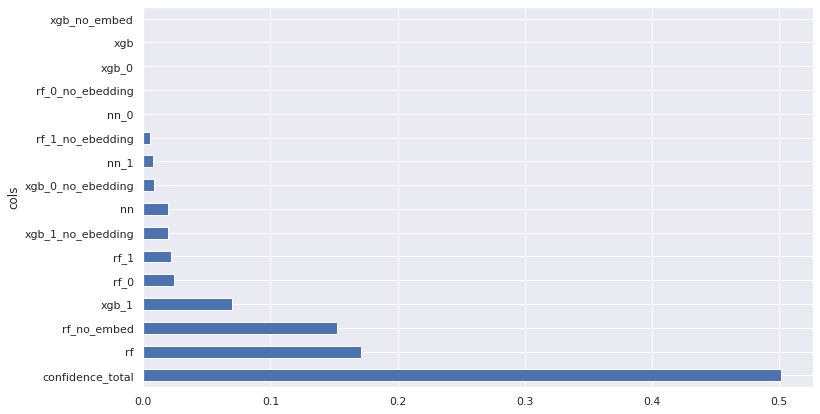

In [ ]:
fi = rf_feat_importance(clf, X_test)
plot_fi(fi[:30]);

In [ ]:
fi[:3]

,cols,imp
15,confidence_total,0.501449
12,rf,0.170892
13,rf_no_embed,0.152573


In [ ]:
to_keep = fi[fi.imp>0.02].cols
print (len(fi.cols), len(to_keep))

xs_df = X_train[to_keep]
valid_xs_df = X_test[to_keep]

16 6


In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0, oob_score=False, min_samples_split=100, n_estimators=5)
clf.fit(xs_df, y_train)
#clf.score(X_train, y_train)
clf.score(valid_xs_df, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7857142857142857

In [ ]:
model = XGBClassifier(max_depth=5,n_estimators=10)
model.fit(X_train, y_train)
model, model.score(X_train, y_train), model.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
 0.8255395683453237,
 0.7214285714285714)

In [ ]:
clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=20)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.7697841726618705, 0.7285714285714285)